Import the project library for glyph generation, classification, plotting, etc.

In [49]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex

import importlib
importlib.reload(lilg)
importlib.reload(lilgplt)
importlib.reload(lilgcls)
importlib.reload(lilgex)

<module 'littleglyphs.examples' from '/home/incide/projects/littleglyphs/littleglyphs/examples.py'>

Import prerequisite libraries.

In [50]:
import copy
import time

import numpy as np
import scipy
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

random_seed = 456

np.random.seed(random_seed)

Generate a glyph _alphabet_ (an array of glyphs each belonging to a unique _category_). From it, making a set of glyphs with slightly different strokes (glyph _permutations_), produce images, then use affine transformations (_distortions_) on those images to produce glyph _variations_.

In [51]:
N_glyphs_in_alphabet = 15

N_bezier_features = 0
N_line_features = 2
N_ellipse_features = 0

N_glyph_permutations = 20
permutation_strength = 0.05

imgsize = 16

N_glyph_raster_distortions = 30
rotat_distort_max = np.pi / 8
shear_distort_max = np.pi / 8
scale_distort_max = 0.15

blur_factor = 1

N_variations_per_glyph = N_glyph_permutations*N_glyph_raster_distortions

time_start = time.time()
print('Generating glyph alphabet and glyph variations... ', end='')

'''
glyphs = []
glyph_categories = list(range(0,N_glyphs_in_alphabet))
for category in glyph_categories:
    glyph = lilg.Glyph(
        [lilg.FeatureBezierCurve() for count in range(0,N_bezier_features)]+
        [lilg.FeatureLineSegment() for count in range(0,N_line_features)]+
        [lilg.FeatureEllipse() for count in range(0,N_ellipse_features)]
    )
    glyph.set_category(category)
    glyph.randomize_all_features()
    glyphs.append(glyph)

glyph_alphabet = lilg.GlyphList(glyphs)
'''


glyph_alphabet = lilg.examples.MNISTlike_glyph_alphabet()
N_glyphs_in_alphabet = len(glyph_alphabet)

glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [
        lilg.DistortionRandomAffine(
            rotat_distort_max = rotat_distort_max, 
            shear_distort_max = shear_distort_max,
            scale_distort_max = scale_distort_max
        )
    ]
)
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)


time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and glyph variations... done in 7.247 sec (0.557 sec per glyph).


Visualise the glyphs and show some examples of glyph rasters.

Ground truth glyphs:


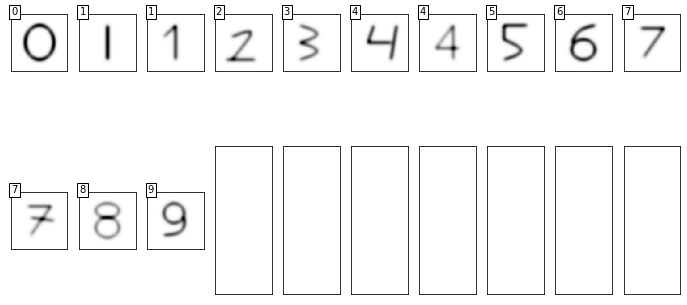

In [53]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

Examples of glyph images:


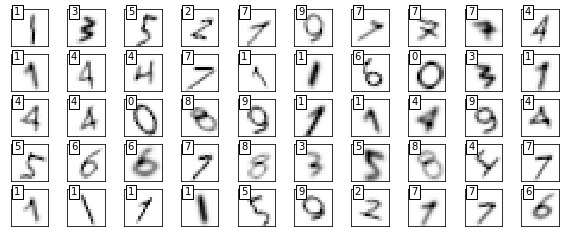

In [57]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

### Categorize the data using a CNN

Make a one-hot encoded category correspondence array for the glyph variations.

In [58]:
category_classes, inverse_category_class_indices = np.unique(glyph_rasters.categories, return_inverse=True)
N_classes = len(category_classes)

X = glyph_rasters.rasters
Y = keras.utils.to_categorical(glyph_rasters.categories, num_classes=N_classes)

We have our data ready to be fed to the categorizer. Split it into training, cross-validation, and test sets.

In [59]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
    
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (4680, 16, 16); Y_train matrix shape: (4680, 10)
X_test  matrix shape: (1560, 16, 16); Y_test  matrix shape: (1560, 10)
X_cv    matrix shape: (1560, 16, 16); Y_cv    matrix shape: (1560, 10)


Prepare a CNN model.

In [62]:
keras.backend.clear_session()
model = lilgcls.make_CNN_model(imgsize, N_classes, complexity = 10)

We have our model. Transform the data into a format that can be fed to it, and start training.

In [63]:
X_train_conv = lilgcls.prep_data_for_CNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_CNN_model(X_cv, imgsize)

#from keras.callbacks import ModelCheckpoint
#checkpoint_filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

h = model.fit(
    X_train_conv, Y_train, 
    epochs=40, batch_size=N_classes*10, 
    verbose=2,
    #callbacks=callbacks_list, 
    validation_data=(X_cv_conv,Y_cv)
)

from IPython.display import Audio
Audio('./bell.ogg',autoplay=True)

Train on 4680 samples, validate on 1560 samples
Epoch 1/40
 - 2s - loss: 1.6361 - acc: 0.4733 - val_loss: 0.8005 - val_acc: 0.8513
Epoch 2/40
 - 2s - loss: 0.7975 - acc: 0.7481 - val_loss: 0.3546 - val_acc: 0.9340
Epoch 3/40
 - 2s - loss: 0.4959 - acc: 0.8365 - val_loss: 0.2326 - val_acc: 0.9404
Epoch 4/40
 - 2s - loss: 0.3408 - acc: 0.8902 - val_loss: 0.1305 - val_acc: 0.9712
Epoch 5/40
 - 2s - loss: 0.2559 - acc: 0.9239 - val_loss: 0.1054 - val_acc: 0.9788
Epoch 6/40
 - 2s - loss: 0.2016 - acc: 0.9378 - val_loss: 0.0784 - val_acc: 0.9840
Epoch 7/40
 - 2s - loss: 0.1616 - acc: 0.9468 - val_loss: 0.0742 - val_acc: 0.9827
Epoch 8/40
 - 2s - loss: 0.1309 - acc: 0.9585 - val_loss: 0.0467 - val_acc: 0.9897
Epoch 9/40
 - 2s - loss: 0.1089 - acc: 0.9647 - val_loss: 0.0419 - val_acc: 0.9878
Epoch 10/40
 - 2s - loss: 0.1043 - acc: 0.9694 - val_loss: 0.0391 - val_acc: 0.9923
Epoch 11/40
 - 2s - loss: 0.0867 - acc: 0.9714 - val_loss: 0.0347 - val_acc: 0.9929
Epoch 12/40
 - 2s - loss: 0.0859 - ac

Show the evolution of training/cross-validation losses and accuracies.

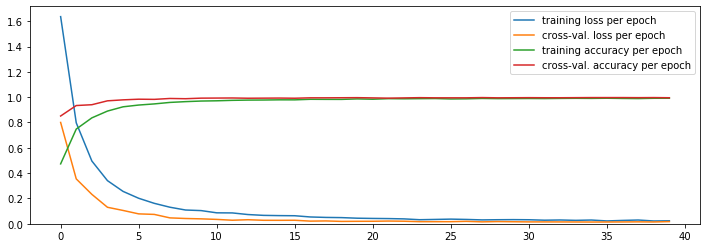

1560/1560 [==============================] - 0s 189us/step
Loss on test set: ~0.00
Accuracy on test set: ~100%


In [64]:
accurs = h.history['acc']
val_accurs = h.history['val_acc']
losses = h.history['loss']
val_losses = h.history['val_loss']
epoch_numbers = h.epoch

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = lilgcls.prep_data_for_CNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

Evaluate the model's predictions for the test data.

In [65]:
Y_predicted = model.predict(X_test_conv, batch_size=128)
Y_predicted_class = np.argmax(Y_predicted, axis=1)
Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_test_class = np.argmax(Y_test, axis=1)

Visualise the examples of test data and predictions on test data.

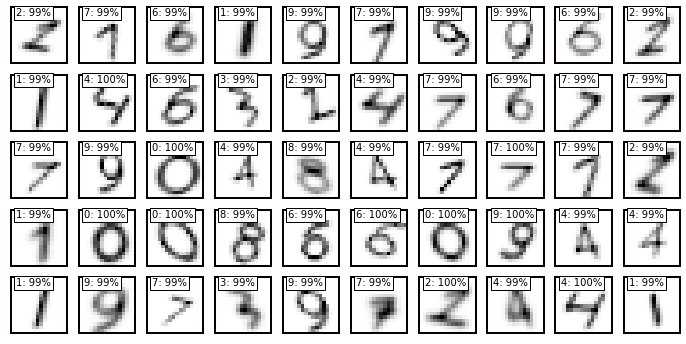

In [66]:
N_images_to_show = 50

vis_imgs = X_test[:N_images_to_show]
vis_categories = Y_predicted_class[:N_images_to_show]
vis_probabilities = Y_predicted_probability[:N_images_to_show]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap = 'hot_r', figsize=(12,6))
plt.show()

Calculate probabilistic confusion entropy matrix. 

The matrix is basically like a regular confusion matrix, but instead of treating the highest output of the classifier as the output class, it treats all outputs of the classifier as "surety" of the classifier in each class. This allows to incorporate into the concept of 'confusion' the cases where the classifier works, but is not very sure in its answers.

Each row corresponds to the "true" class. Each column corresponds to the "surety" of the classifier in its output for the column. So, for instance, an element [4,2] corresponds to the average degree of surety with which the classifier says "it belongs to class 2" when it sees an element that in reality belongs to class 4.
Similarly to the case of a regular confusion matrix, a good classifier will have high values of diagonal elements and low values of all other elements.

( Based on doi:10.3390/e15114969 )


Probabilistic confusion entropy matrix:


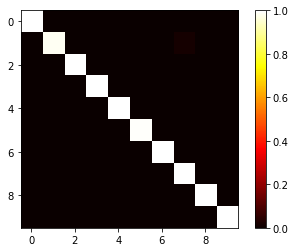

Class with worst performance: 1
Class with best performance:  0


In [67]:
prob_conf_ent_matrix = lilgcls.prob_conf_ent_matrix(Y_test,Y_predicted,N_classes)

worst_class_index = np.diagonal(prob_conf_ent_matrix).argmin()
best_class_index =  np.diagonal(prob_conf_ent_matrix).argmax()

print('Probabilistic confusion entropy matrix:')
#print(np.around(prob_conf_ent_matrix,decimals=3))
plt.imshow(prob_conf_ent_matrix, vmin=0, vmax=1, cmap='hot')
plt.colorbar()
plt.show()
print('Class with worst performance: '+str(worst_class_index))
print('Class with best performance:  '+str(best_class_index))


Show the worst confusion case.

In [68]:
prob_conf_ent_matrix_nodiag = prob_conf_ent_matrix.copy()
np.fill_diagonal(prob_conf_ent_matrix_nodiag,0)

worst_confusion_index = np.unravel_index(
    np.argmax(prob_conf_ent_matrix_nodiag, axis=None), 
    prob_conf_ent_matrix_nodiag.shape
)
print('Most confused pair: class '
      +str(worst_confusion_index[0])
      +' is being mistaken for class '
      +str(worst_confusion_index[1])
      +' with probability '
      +str(np.around(prob_conf_ent_matrix_nodiag[worst_confusion_index],decimals=3))
     )

Most confused pair: class 1 is being mistaken for class 7 with probability 0.016


Visualise examples of the glyphs corresponding to the worst encountered confusion.

[131 256 138 116 220 110 127 227 121 114]
[131 255 138 116 220 110 127 228 121 114]
Examples of class 1:


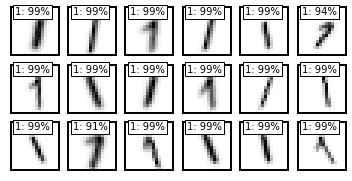

Examples of class 7:


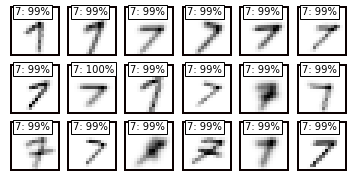

In [69]:
print(np.bincount(Y_test_class))
print(np.bincount(Y_predicted_class))

N_images_to_show = 18

print('Examples of class '+str(worst_confusion_index[0])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[0])[0]
vis_indices = vis_indices[:N_images_to_show]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)                            
                            )
plt.show()

print('Examples of class '+str(worst_confusion_index[1])+':')
vis_indices = np.where(Y_test_class == worst_confusion_index[1])[0]
vis_imgs = X_test[vis_indices]
vis_categories = Y_predicted_class[vis_indices]
vis_probabilities = Y_predicted_probability[vis_indices]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,                             
                             show_probabilities=True,probabilities=vis_probabilities,
                             cmap='hot_r', figsize=(6,3)
                            )
plt.show()


Randomly generate glyphs until spotting a glyph that has a lot of _ambiguity_ for our classifier. An _ambiguous_ glyph is defined as one with which the classifier has trouble assigning it to any of the classes.

Note that this __does not necessarily__ select for a glyph that is the most _dissimilar_ to the glyphs encountered by the classifier. For instance, a glyph that kind of looks like all glyphs in current alphabet would be quite ambiguous. So would be a glyph that doesn't look like any of the glyphs in current alphabet.

In [17]:
best_ambiguity = N_classes # an impossibly big value
ideal_ambiguity_probability = np.ones(N_classes) * (1/N_classes)
worst_glyph_ambiguity = np.sum((prob_conf_ent_matrix[worst_class_index] - ideal_ambiguity_probability)**2)

new_candidate_glyph_ambiguity_threshold = worst_glyph_ambiguity / 10
new_candidate_glyph_ambiguity_maxiter = 30

print(
    'Worst glyph\'s distance from ideal ambiguity: '+
    str(np.around(worst_glyph_ambiguity, decimals=3))
)

print(
    'Generating new glyph to replace the glyph with worst performance (target ambiguity distance: '+
    str(np.around(new_candidate_glyph_ambiguity_threshold,decimals=3))+
    '):'
)
i = 0
while (
    (i < new_candidate_glyph_ambiguity_maxiter) and 
    (best_ambiguity > new_candidate_glyph_ambiguity_threshold)
):
    
    i = i + 1

    new_candidate_glyph = lilg.generate_single_glyph(N_strokes)

    new_glyph_variation_imgs = np.zeros((    
        N_variations_per_glyph, 
        imgsize, imgsize))

    new_glyph_variation_imgs = lilg.generate_glyph_variation_images(new_candidate_glyph, 
        N_glyph_permutations,    permutation_strength,
        N_glyph_img_distortions,  imgsize,   blur_factor,
        rotat_distort_max,  shear_distort_max,  scale_distort_max
    )

    X_new = lilg.prep_data_for_CNN_model(new_glyph_variation_imgs,imgsize)
    Y_new_predicted = model.predict(X_new, batch_size=128)

    Y_new_mean_class_probability = Y_new_predicted.mean(axis=0)
    #print('Candidate for new glyph - average classification:')
    #print(np.around(Y_new_mean_class_probability, decimals=3))
    #print('Candidate for new glyph - square distance from ideal ambiguity:')    
    distance_from_ideal_ambiguity = (Y_new_mean_class_probability - ideal_ambiguity_probability)**2
    #print(np.around(distance_from_ideal_ambiguity, decimals=3))
    total_distance_from_ideal_ambiguity = np.sum(distance_from_ideal_ambiguity)
    #print('Total distance from ideal ambiguity: '+str(np.around(total_distance_from_ideal_ambiguity, decimals=3)))
    #print()
    
    if best_ambiguity>total_distance_from_ideal_ambiguity:
        best_ambiguity = total_distance_from_ideal_ambiguity
        best_new_candidate_glyph = new_candidate_glyph.copy()
        best_glyph_variation_imgs = new_glyph_variation_imgs.copy()
        
    print(
        '\rIteration ' + str(i) + ': '+
        'current distance from ideal ambiguity: '+
        str(np.around(total_distance_from_ideal_ambiguity, decimals=3))+
        '; best: '+
        str(np.around(best_ambiguity, decimals=3)),
        end=''
    )
    

new_candidate_glyph = best_new_candidate_glyph
new_glyph_variation_imgs = best_glyph_variation_imgs
print()
print(
    'Best candidate distance from ideal ambiguity: '+str(np.around(best_ambiguity, decimals=3))+
    ', found in '+str(i)+' iterations (max '+str(new_candidate_glyph_ambiguity_maxiter)+' iterations).'
)        

Worst glyph's distance from ideal ambiguity: 0.086
Generating new glyph to replace the glyph with worst performance (target ambiguity distance: 0.009):
Iteration 30: current distance from ideal ambiguity: 0.05; best: 0.0399
Best candidate distance from ideal ambiguity: 0.039, found in 30 iterations (max 30 iterations).


Examples of new glyph images:


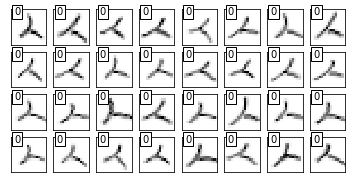

In [18]:
print('Examples of new glyph images:')
N_images_to_show = 32

random_indices = np.arange(len(new_glyph_variation_imgs))
np.random.shuffle(random_indices)
vis_imgs = new_glyph_variation_imgs[random_indices[:N_images_to_show]]
vis_categories = np.zeros(N_images_to_show)

fig, _ = luws.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,
                             figsize=(6,3), 
                            )
plt.show()

# fig.savefig('./results/test.png',bbox_inches='tight')

Incorporate the new glyph in place of the old one. Generate a new set of rasters.

In [19]:
glyph_alphabet[worst_class_index] = new_candidate_glyph

time_start = time.time()
print('Generating new glyph variations... ', end='')

glyph_variation_imgs = np.zeros((    
    N_glyphs_in_alphabet*N_variations_per_glyph, 
    imgsize, imgsize))
for i in range(0,N_glyphs_in_alphabet):
    glyph = glyph_alphabet[i]
    curr_glyph_variation_imgs = luws.generate_glyph_variation_images(glyph, 
        N_glyph_permutations,    permutation_strength,
        N_glyph_img_distortions,  imgsize,   blur_factor,
        rotat_distort_max,  shear_distort_max,  scale_distort_max
    )
    glyph_variation_imgs[
        (i*N_variations_per_glyph):((i+1))*N_variations_per_glyph,
        :,:] = curr_glyph_variation_imgs


glyph_variation_img_categories = np.zeros((N_glyphs_in_alphabet*N_variations_per_glyph))
for i in range(0,N_glyphs_in_alphabet):
    glyph_variation_img_categories[(i*N_variations_per_glyph):((i+1)*N_variations_per_glyph)] = i    
    
time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')

Generating new glyph variations... done in 21.069 sec (2.107 sec per glyph).
